## ARCH and GARCH Models

ARCH and GARCH are **time series models** that model **changing volatility over time**, especially useful for financial data like stock returns or exchange rates.

### 1. Why Traditional Models Aren’t Enough

- Traditional models like AR, MA, ARMA, ARIMA focus on **predicting the mean** of a series.  
- They **assume constant variance** over time.  
- Financial data often shows **volatility clustering**: periods of high and low variability.  
- Using ARIMA alone may predict the average trend but **fail to capture extreme volatility**.  
- ARCH/GARCH models address this by modeling **time-varying variance**.

### 2. ARCH (Autoregressive Conditional Heteroskedasticity)

- ARCH models are used to capture **time-varying volatility** in a time series. 
- They are particularly useful in financial data, like stocks or exchange rates, where periods of `high` and `low volatility` tend to cluster together.
- Unlike traditional models such as AR, MA, or ARIMA, which **assume constant variance**, ARCH explicitly models variance as changing over time.
- `key concept`: The current volatility (or variance) of a series depends on the squared errors from previous periods. In simple terms:
    - If yesterday there was a big shock (a large deviation from the expected value), today is likely to be more volatile.
    - If yesterday was calm, today is likely calm as well.

Limitations:
- Only considers past shocks, ignoring past variances.
- Can require many lagged terms (large q) to capture long-term volatility, which can be inefficient.

### 3. GARCH (Generalized ARCH)

- Extends ARCH by including **past variances** along with past shocks.  
- **Key Idea:** Current volatility depends on **both past shocks(squared errors) and past volatility**.

Intuition:
- `past shocks`: If there have been large shocks recently, today is likely more volatile.
- `past volatility`: Even if yesterday’s shock wasn’t huge, if the market has been volatile over the past few days, today’s volatility can still be high.

- More flexible and practical for financial data than ARCH alone.  
- **Use Case:** Forecasting volatility in stocks, crypto, commodities.

`GARCH(1,1)` is the most widely used: it considers only the previous period’s squared error and variance but captures volatility well in most financial time series.

### 4. Key Concepts

- ARCH → variance depends on **past squared errors**.  
- GARCH → variance depends on **past squared errors and past variances**.  
- Both are **time series models** used when variance is **not constant**.  
- Useful for modeling **volatility clustering** in financial data.

### 5. Analogy

- ARCH → Looks at the **immediate past** to predict volatility.  
- GARCH → Looks at the **immediate past and past patterns of volatility**.  

**Summary:**  
ARCH/GARCH models are used to forecast **how “wild” or volatile** a time series will be, rather than just predicting the mean.


### Implementation

#### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
# darkgrid style
import seaborn as sns
sns.set_style('darkgrid')

#### Fetch Bitcoin Data

We’ll fetch daily Bitcoin `(BTC-USD)` prices:

In [33]:
# Fetch Bitcoin daily price data from Yahoo Finance
btc_data = yf.download('BTC-USD', start='2020-01-01', end='2025-09-23', interval='1d')

# Display first few rows
print(btc_data.head())

C:\Users\user\AppData\Local\Temp\ipykernel_11708\681096167.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_data = yf.download('BTC-USD', start='2020-01-01', end='2025-09-23', interval='1d')
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open       Volume
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD      BTC-USD
Date                                                                       
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095


In [34]:
# Remove the multi-level column index
btc_data.columns = btc_data.columns.get_level_values(0)

# Check the result
print(btc_data.head())

Price             Close         High          Low         Open       Volume
Date                                                                       
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095


### BTC Price Trend

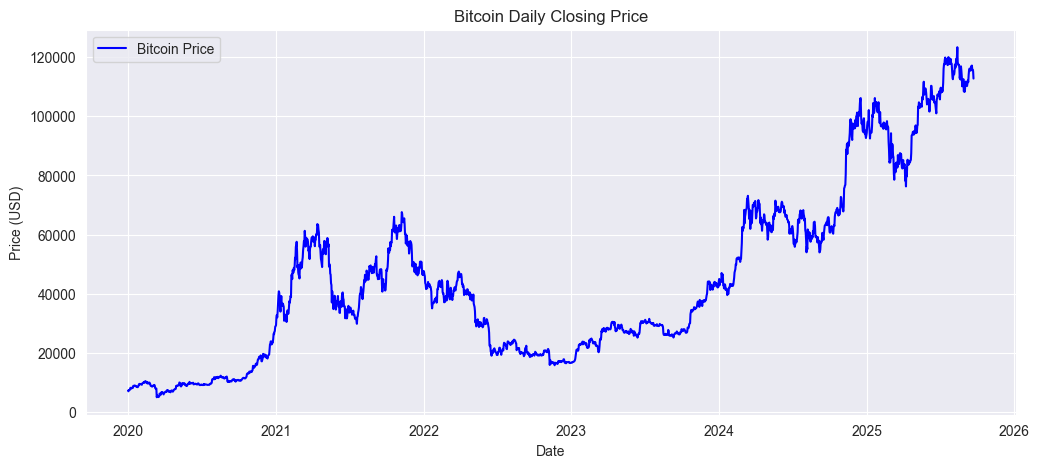

In [35]:
plt.figure(figsize=(12,5))
plt.plot(btc_data['Close'], label='Bitcoin Price', color='blue')
plt.title('Bitcoin Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

#### 1. Compute Daily Returns

ARCH/GARCH models work on returns, not raw prices:

In [36]:
# Compute daily returns in percentage terms
btc_data['Returns'] = btc_data['Close'].pct_change() * 100

# Drop the first NaN
btc_returns = btc_data['Returns'].dropna()

# Preview
print(btc_returns.head())

Date
2020-01-02   -2.981929
2020-01-03    5.145166
2020-01-04    0.895487
2020-01-05    0.008915
2020-01-06    4.829126
Name: Returns, dtype: float64


- Daily return measures how much Bitcoin’s closing price changed (in %) from one day to the next.
- Returns are typically `stationary in the mean`, which ARCH/GARCH require.

#### Visualize Returns

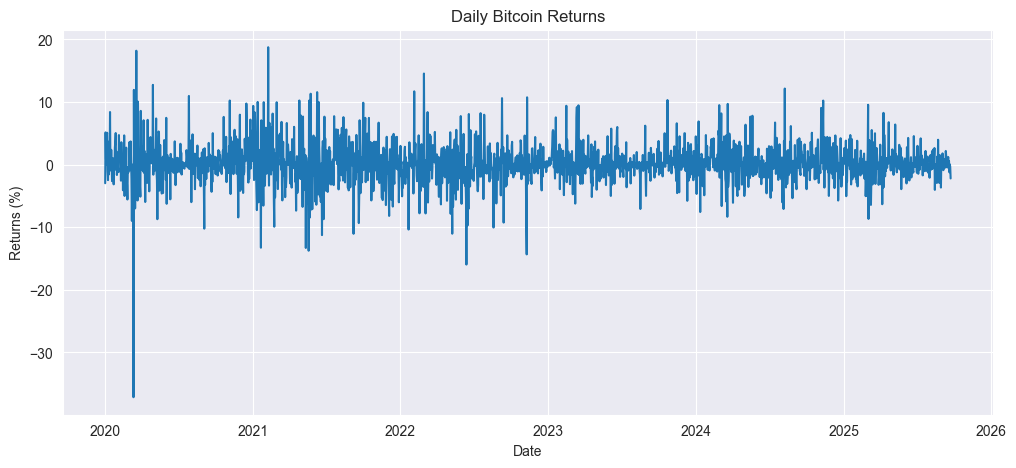

In [37]:
plt.figure(figsize=(12,5))
plt.plot(btc_returns)
plt.title('Daily Bitcoin Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.show()


### Check Stationarity of Returns

Before fitting a GARCH model, test if returns are stationary in the mean using the Augmented Dickey–Fuller (ADF) test.

In [38]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(btc_returns)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("Reject the null hypothesis - series is stationary.")

ADF Statistic: -14.977858116450253
p-value: 1.1739829183925055e-27
Reject the null hypothesis - series is stationary.


### Train-Test split

In [39]:
train_size = int(len(btc_returns) * 0.8)
train_returns = btc_returns[:train_size]
test_returns  = btc_returns[train_size:]

print("Train size:", len(train_returns), "Test size:", len(test_returns))

Train size: 1672 Test size: 419


### Visualize the train-test split

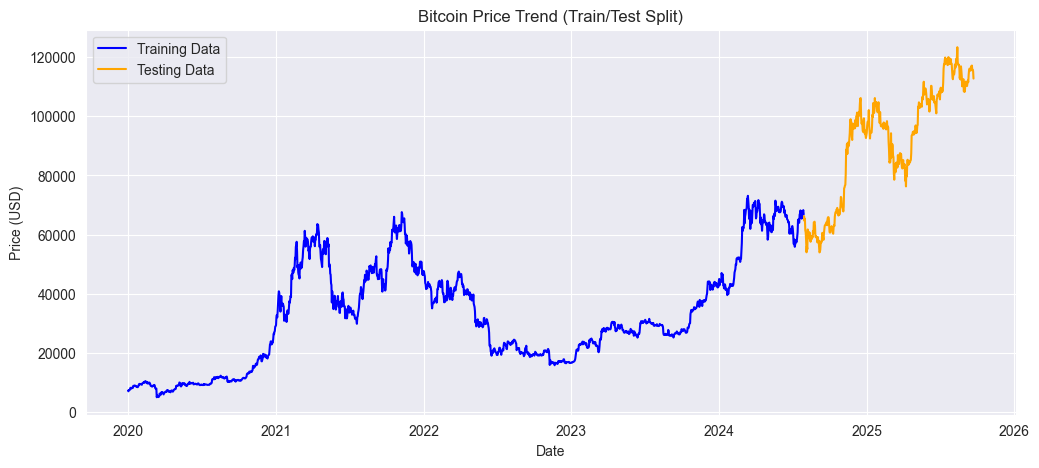

In [40]:
# Get the corresponding date indices for the split
train_dates = btc_data.index[:train_size]
test_dates  = btc_data.index[train_size:]

plt.figure(figsize=(12,5))

# Plot training period
plt.plot(train_dates, btc_data['Close'].iloc[:train_size],
         label='Training Data', color='blue')

# Plot testing period
plt.plot(test_dates, btc_data['Close'].iloc[train_size:],
         label='Testing Data', color='orange')

plt.title('Bitcoin Price Trend (Train/Test Split)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


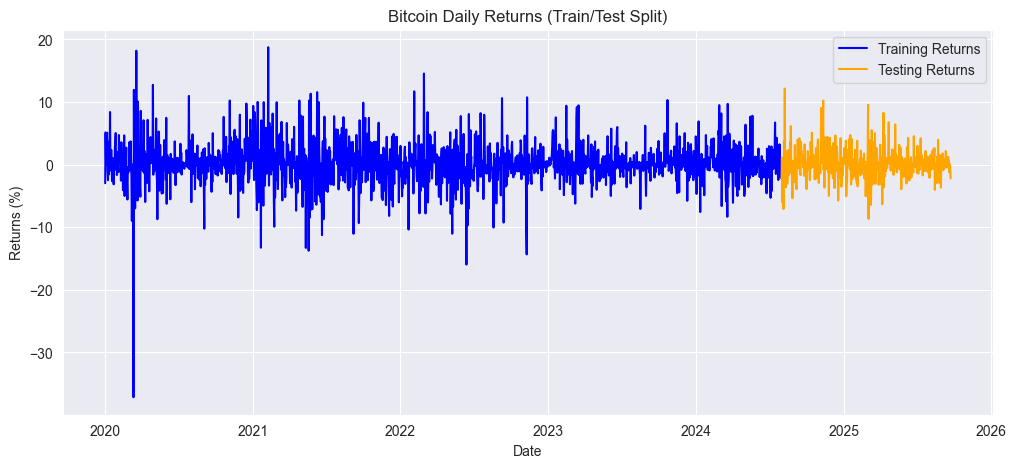

In [41]:
plt.figure(figsize=(12,5))

# Plot training returns
plt.plot(train_returns.index, train_returns,
         label='Training Returns', color='blue')

# Plot testing returns
plt.plot(test_returns.index, test_returns,
         label='Testing Returns', color='orange')

plt.title('Bitcoin Daily Returns (Train/Test Split)')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()
plt.show()

#### Fit an GARCH Model

In [49]:
from arch import arch_model

# Fit a GARCH(1,1) model
garch_mod = arch_model(train_returns, vol='GARCH', p=1, q=1, dist='normal')
garch_fit = garch_mod.fit(disp='off')

# Model summary
print("\nGARCH(1,1) model summary:")
print(garch_fit.summary())


GARCH(1,1) model summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 logret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3328.53
Distribution:                  Normal   AIC:                          -6649.06
Method:            Maximum Likelihood   BIC:                          -6627.37
                                        No. Observations:                 1672
Date:                Wed, Sep 24 2025   Df Residuals:                     1671
Time:                        07:32:32   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.9365e-03  8.247e-0

c:\Users\user\Desktop\data-science-class\07-Deep_Learning\env\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [50]:
# Rescale returns to avoid convergence issues
train_scaled = train_returns * 100

garch_mod = arch_model(train_scaled, vol='GARCH', p=1, q=1, dist='normal')
garch_fit = garch_mod.fit(disp='off')

print("\nGARCH(1,1) model summary (returns scaled x100):")
print(garch_fit.summary())


GARCH(1,1) model summary (returns scaled x100):
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 logret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4361.11
Distribution:                  Normal   AIC:                           8730.22
Method:            Maximum Likelihood   BIC:                           8751.91
                                        No. Observations:                 1672
Date:                Wed, Sep 24 2025   Df Residuals:                     1671
Time:                        07:34:05   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             

### Generate forecasts on the test period

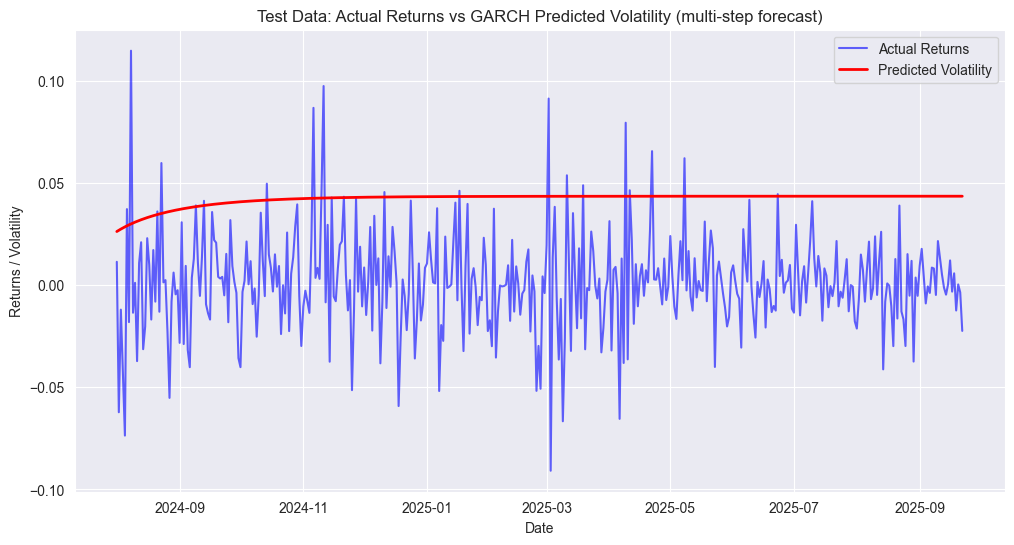

In [ ]:
plt.figure(figsize=(12,6))

# Actual returns (could be small; show as thin line)
plt.plot(test_returns.index, test_returns, label='Actual Returns', color='blue', alpha=0.6)

# Predicted volatility (std dev of returns)
plt.plot(vol_forecast_series.index, vol_forecast_series, label='Predicted Volatility', color='red', linewidth=2)

plt.title('Test Data: Actual Returns vs GARCH Predicted Volatility (multi-step forecast)')
plt.xlabel('Date')
plt.ylabel('Returns / Volatility')
plt.legend()
plt.grid(True)
plt.show()
